<a href="https://colab.research.google.com/github/pnevmap/dcu-ml/blob/main/planetfour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Planet four image classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import sklearn.metrics as metrics
import tqdm

from torch.utils.data import DataLoader
from torchvision.datasets.folder import pil_loader
from pathlib import Path
from PIL import Image

Change the device to "cpu" if you want to train on a CPU instead of a GPU.

In [ ]:
device = 'cpu'

## Dataset

Here we define a custom Dataset object for the Planet Four data. You can read more about this in the PyTorch documentation: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
class PlanetFourDataset(object):
    def __init__(self, split='train', transform=None, loader=pil_loader):
        super().__init__()
        self.split = split
        self.base_dir = Path('data/splits')
        self.image_dir = self.base_dir / split
        self.labels_file = self.base_dir / (split + '.csv')
        self.labels_df = pd.read_csv(self.labels_file)
        self.transform = transform
        self.loader = loader
        
    def __getitem__(self, index):
        row = self.labels_df.iloc[index]
        filename = self.image_dir / (row.tile_id + '.jpg')
        fans = int(row.fans)
        blotches = int(row.blotches)
        image = self.loader(str(filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.tensor([fans, blotches], dtype=torch.float32)
    
    def __len__(self):
        return len(self.labels_df)

## Data augmentation

It is standard practice in deep learning to augment the training examples to prevent the network from overfitting. Here I use some standard augmentations such as randomly mirroring the images.

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))                  
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])

## Data loaders

In PyTorch, the data loaders take care of spinning up threads to load batches of data into memory from the dataset object.

In [ ]:
train_set = PlanetFourDataset('train', transform=train_transform)
valid_set = PlanetFourDataset('valid', transform=valid_transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False)

## Load a pretrained model

Here we'll use ResNet50 model that has been pretrained on ImageNet and replace the final layer with a new one suited to our problem.

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 2)
model.to(device);

## Loss

Images can contain fans, blotches, both, or neither. You could treat this as a four class softmax problem, or two binary classification problems. Here I take the latter approach and use a binary cross entropy loss. 

In [ ]:
criterion = nn.BCEWithLogitsLoss()

## Optimizer

Stochastic gradient descent with momentum

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

## Training and validation functions

In [ ]:
avg_train_losses = []
avg_valid_losses = []
valid_accuracies = []


def train_for_epoch(optimizer):
    model.train()

    train_losses = []

    for batch, target in tqdm.tqdm(train_loader):

        # data to GPU
        batch = batch.to(device)
        target = target.to(device)

        # reset optimizer
        optimizer.zero_grad()

        # forward pass
        predictions = model(batch)
        #breakpoint()

        # calculate loss
        loss = criterion(predictions, target)

        # backward pass
        loss.backward()

        # parameter update
        optimizer.step()

        # track loss
        train_losses.append(float(loss.item()))

    train_losses = np.array(train_losses)
    return train_losses


def validate():
    model.eval()

    valid_losses = []
    y_true, y_prob = [], []

    with torch.no_grad():
        for batch, target in valid_loader:

            # move data to the device
            batch = batch.to(device)
            target = target.to(device)

            # make predictions
            predictions = model(batch)

            # calculate loss
            loss = criterion(predictions, target)
            
            # logits -> probabilities
            torch.sigmoid_(predictions)

            # track losses and predictions
            valid_losses.append(float(loss.item()))
            y_true.extend(target.cpu().numpy())
            y_prob.extend(predictions.cpu().numpy())
            
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = y_prob > 0.5
    valid_losses = np.array(valid_losses)

    # calculate validation accuracy from y_true and y_pred
    fan_accuracy = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    blotch_accuracy = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    exact_accuracy = np.all(y_true == y_pred, axis=1).mean()

    # calculate the mean validation loss
    valid_loss = valid_losses.mean()

    return valid_loss, fan_accuracy, blotch_accuracy, exact_accuracy


def train(epochs, first_epoch=1):
    for epoch in range(first_epoch, epochs+first_epoch):

        # train
        train_loss = train_for_epoch(optimizer)

        # validation
        valid_loss, fan_accuracy, blotch_accuracy, both_accuracy = validate()
        print(f'[{epoch:02d}] train loss: {train_loss.mean():0.04f}  '
              f'valid loss: {valid_loss:0.04f}  ',
              f'fan acc: {fan_accuracy:0.04f}  ',
              f'blotch acc: {blotch_accuracy:0.04f}  ',
              f'both acc: {both_accuracy:0.04f}'
        )
        
        # update learning curves
        avg_train_losses.append(train_loss.mean())
        avg_valid_losses.append(valid_loss)
        valid_accuracies.append((fan_accuracy, blotch_accuracy, both_accuracy))
        
        # save checkpoint
        torch.save(model, f'checkpoints/resnet50_{epoch:03d}.pkl')

## Constant classifier accuracy

Evaluate how accurate would a $f(x) = \text{"most common class"}$ classifier be? 

In [ ]:
def constant_clf_accuracy():
    y_true, y_pred = [], []
    with torch.no_grad():
        for _, target in valid_loader:
            y_true.extend(target.cpu().numpy())
            y_pred.extend(np.ones((target.shape[0], 2), dtype=np.float32))
            
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
        
    # calculate validation accuracy from y_true and y_pred
    f = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    b = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    t = np.all(y_true == y_pred, axis=1).mean()
    print(f'fan: {f}  blotch: {b}  both: {t}')
    return f, b, t

In [ ]:
const_fa, const_ba, const_ta = constant_clf_accuracy()

fan: 0.6218644702358667  blotch: 0.8083114938225384  both: 0.4399101460127293


## Train the model
Call the ``train(n)`` function to train for ``n`` epochs.

In [ ]:
train(5)

100%|██████████| 376/376 [19:40<00:00,  3.14s/it]


[01] train loss: 0.4792  valid loss: 0.4250   fan acc: 0.7799   blotch acc: 0.8326   both acc: 0.6455


100%|██████████| 376/376 [21:13<00:00,  3.39s/it]


[02] train loss: 0.3995  valid loss: 0.4034   fan acc: 0.7888   blotch acc: 0.8390   both acc: 0.6601


100%|██████████| 376/376 [20:27<00:00,  3.27s/it]


[03] train loss: 0.3556  valid loss: 0.3859   fan acc: 0.8079   blotch acc: 0.8394   both acc: 0.6762


100%|██████████| 376/376 [21:10<00:00,  3.38s/it]


[04] train loss: 0.3211  valid loss: 0.3973   fan acc: 0.8016   blotch acc: 0.8465   both acc: 0.6821


100%|██████████| 376/376 [19:00<00:00,  3.03s/it]


[05] train loss: 0.2902  valid loss: 0.4136   fan acc: 0.8023   blotch acc: 0.8289   both acc: 0.6630


## Plot train and validation loss

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import seaborn as sns
sns.set_style('white')

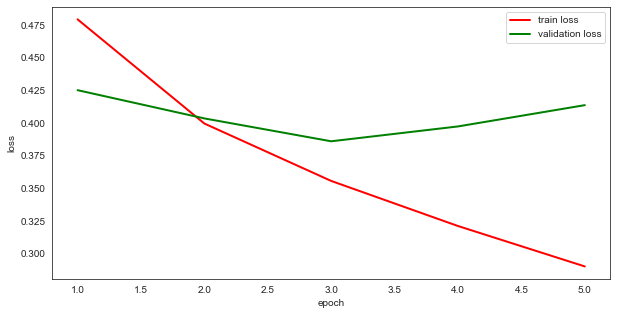

In [ ]:
def plot_loss(avg_train_losses, avg_valid_losses):
    n = len(avg_train_losses)
    figure(figsize=(10,5))
    plot(range(1, n+1), avg_train_losses, 'r-', lw=2, label='train loss')
    plot(range(1, n+1), avg_valid_losses, 'g-', lw=2, label='validation loss')
    legend()
    xlabel('epoch')
    ylabel('loss')
    show()
    
plot_loss(avg_train_losses, avg_valid_losses)

## Plot accuracy metrics

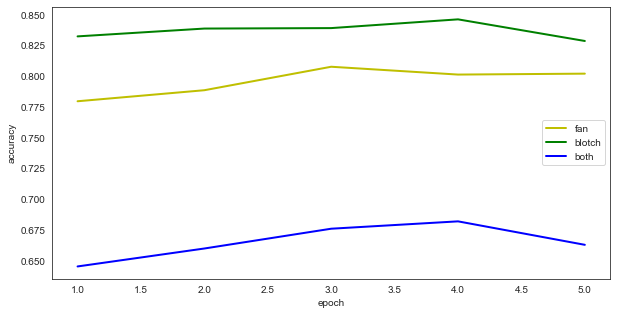

In [ ]:
def deconstruct_accuracies(valid_accuracies):
    fan_accuracies = [valid_accuracy[0] for valid_accuracy in valid_accuracies]
    blotch_accuracies = [valid_accuracy[1] for valid_accuracy in valid_accuracies]
    both_accuracies = [valid_accuracy[2] for valid_accuracy in valid_accuracies]
    return fan_accuracies, blotch_accuracies, both_accuracies

def plot_accuracies(accuracies):
    n = len(accuracies[0])
    figure(figsize=(10,5))
    plot(range(1, n+1), accuracies[0], 'y-', lw=2, label='fan')
    plot(range(1, n+1), accuracies[1], 'g-', lw=2, label='blotch')
    plot(range(1, n+1), accuracies[2], 'b-', lw=2, label='both')
    legend()
    xlabel('epoch')

    ylabel('accuracy')
    show()
    
plot_accuracies(deconstruct_accuracies(valid_accuracies))

### Compare model accuracies with the accuracy of the constant estimator

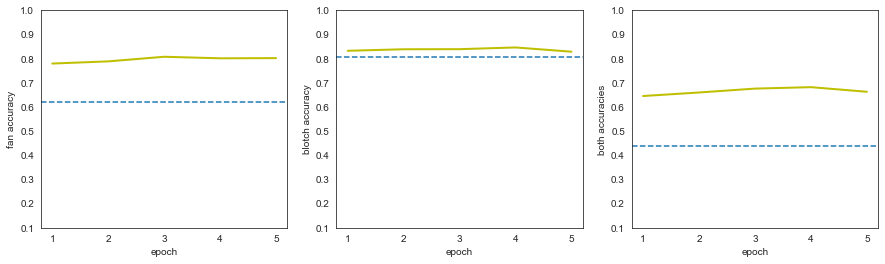

In [ ]:
def plot_compare_accuracies_with_consts(accuracies):
    n = len(accuracies[0])
    plt.figure(figsize=(15,4))
    subplot(131)
    plot(range(1, n+1), accuracies[0], 'y-', lw=2, label='fan accuracy')
    axhline(const_fa, linestyle='--', label='constant fan accuracy')
    xlabel('epoch')
    ylabel('fan accuracy')
    ylim([0.1, 1])

    subplot(132)
    plot(range(1, n+1), accuracies[1], 'y-', lw=2, label='blotch accuracy')
    axhline(const_ba, linestyle='--', label='constant blotch accuracy')
    xlabel('epoch')
    ylabel('blotch accuracy')
    ylim([0.1, 1])

    subplot(133)
    plot(range(1, n+1), accuracies[2], 'y-', lw=2, label='total accuracies')
    axhline(const_ta, linestyle='--' )
    xlabel('epoch')
    ylabel('both accuracies')
    ylim([0.1, 1])

    show()

plot_compare_accuracies_with_consts(deconstruct_accuracies(valid_accuracies))

### Train for 2 more epocs, plot metrics

In [ ]:
train(2, 6)

100%|██████████| 376/376 [18:29<00:00,  2.95s/it]


[06] train loss: 0.2575  valid loss: 0.4232   fan acc: 0.8023   blotch acc: 0.8270   both acc: 0.6604


100%|██████████| 376/376 [18:29<00:00,  2.95s/it]


[07] train loss: 0.2223  valid loss: 0.4528   fan acc: 0.7975   blotch acc: 0.8289   both acc: 0.6627


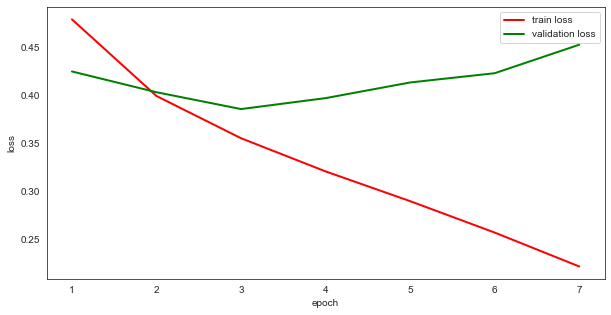

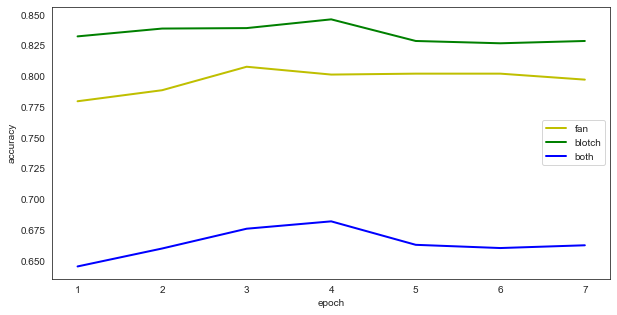

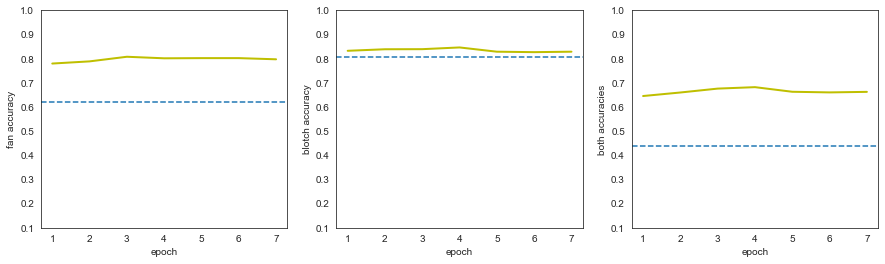

In [ ]:
def plot_model_metrics(avg_train_losses, avg_valid_losses, accuracies):
    accuracies = deconstruct_accuracies(valid_accuracies)
    plot_loss(avg_train_losses, avg_valid_losses)
    plot_accuracies(accuracies)
    plot_compare_accuracies_with_consts(accuracies)

plot_model_metrics(avg_train_losses, avg_valid_losses, valid_accuracies)

## Change the model architecture to ResNet 101

In [ ]:
# change model architecture to ResNet101
model = models.resnet101(pretrained=True)
model.fc = nn.Linear(2048, 2)
model.to(device);
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)


def train_resnet101(epochs, first_epoch=1):
    avg_train_losses = []
    avg_valid_losses = []
    valid_accuracies = []
    for epoch in range(first_epoch, epochs+first_epoch):

        # train
        train_loss = train_for_epoch(optimizer)

        # validation
        valid_loss, fan_accuracy, blotch_accuracy, both_accuracy = validate()
        print(f'[{epoch:02d}] train loss: {train_loss.mean():0.04f}  '
              f'valid loss: {valid_loss:0.04f}  ',
              f'fan acc: {fan_accuracy:0.04f}  ',
              f'blotch acc: {blotch_accuracy:0.04f}  ',
              f'both acc: {both_accuracy:0.04f}'
        )
        
        # update learning curves
        avg_train_losses.append(train_loss.mean())
        avg_valid_losses.append(valid_loss)
        valid_accuracies.append((fan_accuracy, blotch_accuracy, both_accuracy))
        
        # save checkpoint
        torch.save(model, f'checkpoints/resnet101_{epoch:03d}.pkl')
    return avg_train_losses, avg_valid_losses, valid_accuracies

In [ ]:
learning_metrics = train_resnet101(5)

100%|██████████| 376/376 [33:12<00:00,  5.30s/it]


[01] train loss: 0.4744  valid loss: 0.4285   fan acc: 0.7716   blotch acc: 0.8267   both acc: 0.6297


100%|██████████| 376/376 [32:22<00:00,  5.17s/it]


[02] train loss: 0.3931  valid loss: 0.4095   fan acc: 0.7877   blotch acc: 0.8371   both acc: 0.6578


100%|██████████| 376/376 [32:14<00:00,  5.14s/it]


[03] train loss: 0.3482  valid loss: 0.4029   fan acc: 0.7960   blotch acc: 0.8383   both acc: 0.6649


100%|██████████| 376/376 [32:14<00:00,  5.15s/it]


[04] train loss: 0.3074  valid loss: 0.4156   fan acc: 0.7952   blotch acc: 0.8379   both acc: 0.6623


100%|██████████| 376/376 [32:05<00:00,  5.12s/it]


[05] train loss: 0.2681  valid loss: 0.4410   fan acc: 0.7926   blotch acc: 0.8386   both acc: 0.6672


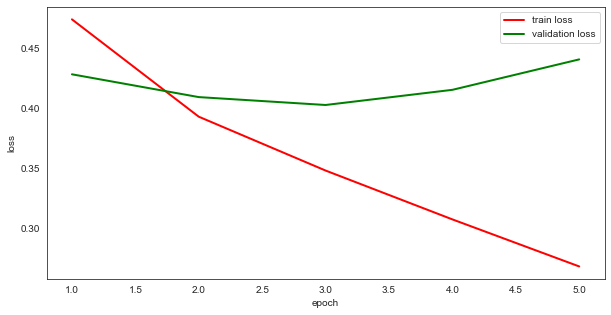

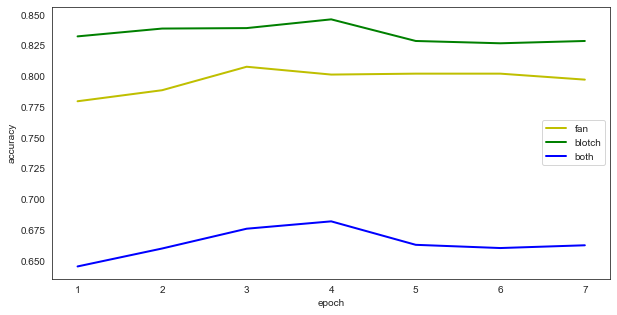

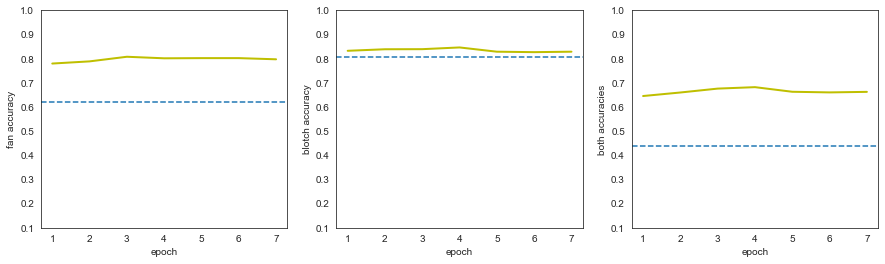

In [ ]:
plot_model_metrics(learning_metrics[0], learning_metrics[1], learning_metrics[2])

## Change data augmentation strategy

In [ ]:
# change dataset augmentation policy
train_transform = transforms.Compose([
    transforms.Resize(224),                                 
    transforms.RandomCrop(192),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomErasing()
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])

train_set = PlanetFourDataset('train', transform=train_transform)
valid_set = PlanetFourDataset('valid', transform=train_transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False)

## Change model architecture back to ResNet50

In [ ]:
# reload the previously saved model
model = torch.load('checkpoints/resnet50_007.pkl')
model.fc = nn.Linear(2048, 2)
model.to(device);
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
train(3,8)

100%|██████████| 376/376 [1:24:21<00:00, 13.46s/it]


[08] train loss: 0.5360  valid loss: 1.1146   fan acc: 0.3811   blotch acc: 0.8083   both acc: 0.3673


100%|██████████| 376/376 [1:27:45<00:00, 14.00s/it]


[09] train loss: 0.5120  valid loss: 0.5412   fan acc: 0.6597   blotch acc: 0.8083   both acc: 0.5283


100%|██████████| 376/376 [1:33:25<00:00, 14.91s/it]


[10] train loss: 0.4998  valid loss: 0.5310   fan acc: 0.6623   blotch acc: 0.8068   both acc: 0.5451


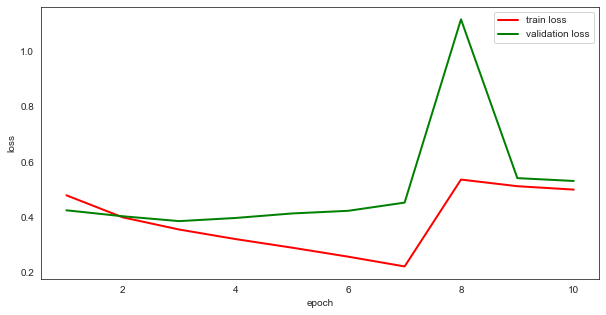

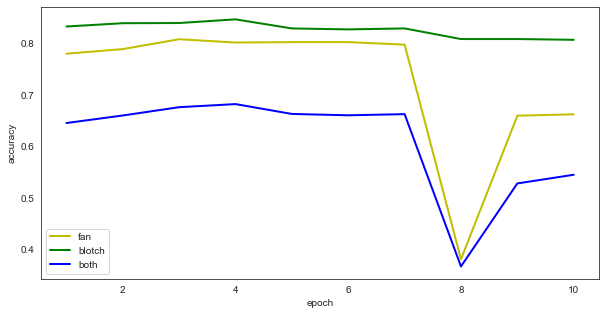

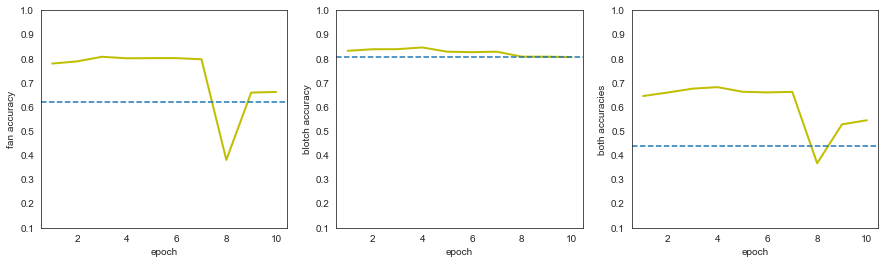

In [ ]:
plot_model_metrics(avg_train_losses, avg_valid_losses, valid_accuracies)

## Experiment with Adam optimizer and learning rate = 0.002

100%|██████████| 376/376 [1:31:40<00:00, 14.63s/it]


[11] train loss: 0.5392  valid loss: 0.5634   fan acc: 0.6080   blotch acc: 0.8083   both acc: 0.4886


100%|██████████| 376/376 [1:34:42<00:00, 15.11s/it]


[12] train loss: 0.5237  valid loss: 0.5332   fan acc: 0.6765   blotch acc: 0.8034   both acc: 0.5399


100%|██████████| 376/376 [2:06:21<00:00, 20.16s/it]  


[13] train loss: 0.5164  valid loss: 0.5241   fan acc: 0.6806   blotch acc: 0.8083   both acc: 0.5350


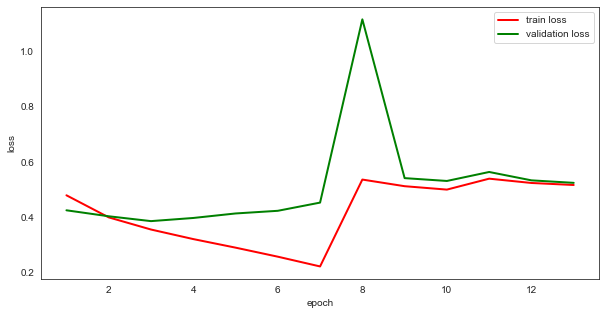

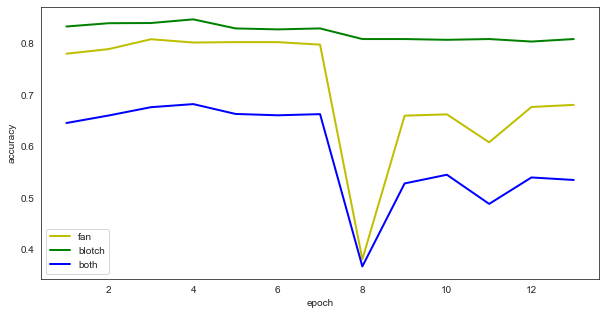

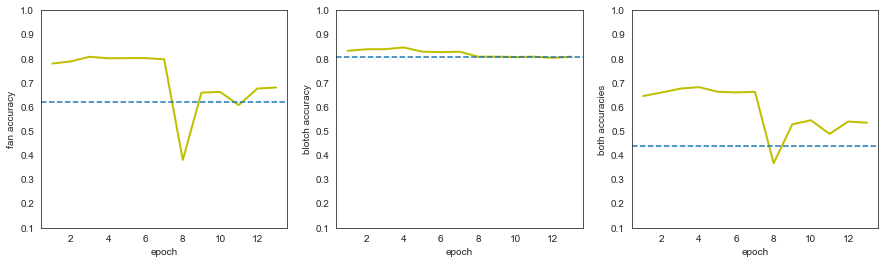

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4)
train(1,11)
plot_model_metrics(avg_train_losses, avg_valid_losses, valid_accuracies)

## Falling back to the ResNet50 model with SGD optimizer, learning rate=0.001

In [ ]:
null_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_set = PlanetFourDataset('test', transform=null_transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
model = torch.load('checkpoints/resnet50_007.pkl')
model.fc = nn.Linear(2048, 2)
model.to(device);
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

## Evaluate with the test set

### Calc metrics

In [ ]:
def test():
    model.eval()

    test_losses = []
    y_true, y_prob = [], []

    with torch.no_grad():
        for batch, target in test_loader:

            # move data to the device
            batch = batch.to(device)
            target = target.to(device)

            # make predictions
            predictions = model(batch)

            # calculate loss
            loss = criterion(predictions, target)
            
            # logits -> probabilities
            torch.sigmoid_(predictions)

            # track losses and predictions
            test_losses.append(float(loss.item()))
            y_true.extend(target.cpu().numpy())
            y_prob.extend(predictions.cpu().numpy())
            #print(batch)
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = y_prob > 0.5

    # calculate validation accuracy from y_true and y_pred
    fan_accuracy = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    blotch_accuracy = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    exact_accuracy = np.all(y_true == y_pred, axis=1).mean()

    # calculate the mean validation loss
    test_loss = np.mean(test_losses)
    
    return test_loss, fan_accuracy, blotch_accuracy, exact_accuracy

In [ ]:
test()

(0.7114183002329887,
 0.6088274932614556,
 0.44036388140161725,
 0.2530323450134771)

### Use the model to label images

[('fans', 0.7609483003616333), ('blotches', 0.5379672050476074)]


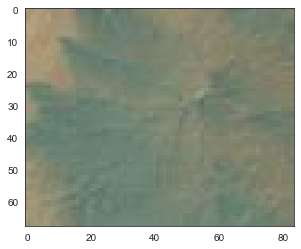

In [ ]:
from PIL import Image

def label_image(img):
    plt.imshow(img)
    img_t = null_transform(img)
    batch_t = torch.unsqueeze(img_t, 0)

    out = model(batch_t)
    labels = ['fans','blotches']
    _, indices = torch.sort(out, descending=True)
    percentage = torch.sigmoid_(out[0])
    #y_prob.extend(percentage.cpu().numpy())
    print([(labels[idx], percentage[idx].item()) for idx in indices[0][:2]])
    
    

label_image(Image.open('data/splits/test/APF0000387.jpg'))    

[('fans', 0.7148586511611938), ('blotches', 0.521053671836853)]


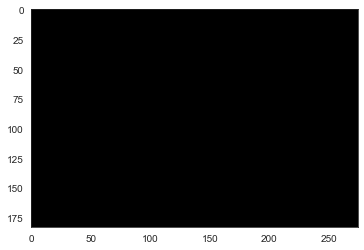

In [ ]:
label_image(Image.open('data/splits/test/white.jpg'))    

[('fans', 0.7617731094360352), ('blotches', 0.3490726947784424)]


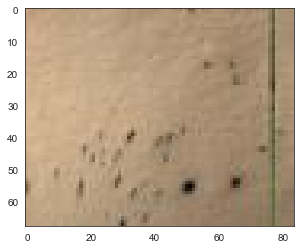

In [ ]:
label_image(Image.open('data/splits/test/APF0000199.jpg'))

[('fans', 0.7446072101593018), ('blotches', 0.45607879757881165)]


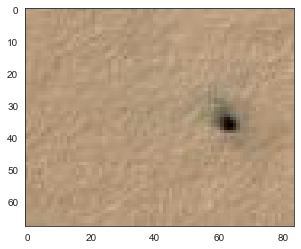

In [ ]:
label_image(Image.open('data/splits/test/APF000006m.jpg'))

[('fans', 0.7247772216796875), ('blotches', 0.4366506040096283)]


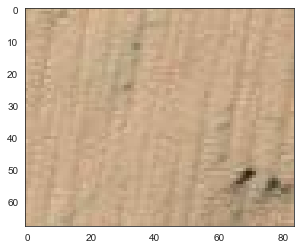

In [ ]:
label_image(Image.open('data/splits/test/APF000093u.jpg'))

[('fans', 0.7924663424491882), ('blotches', 0.5871742963790894)]


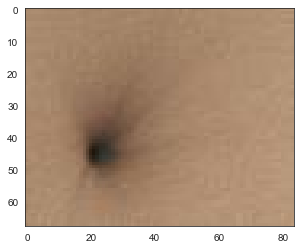

In [ ]:
label_image(Image.open('data/splits/test/APF00005e9.jpg'))